In [21]:
using Plots
include("mpa_model.jl")
m = MpaModel;

Definitions of model parameters.  

In [28]:
K = 1 # ton fish km^-2
r = 0.5 # Intrinsic growth rate of fish populations
A = 100 # Area of fishing ground, km^2
α = 0.00 # Proportion of fishing ground in MPA
μ = 0.01 # Fish spillover rate

# Biomass in reserve and open areas. Both start at carrying capacity
Nreserve = A * α * K
Nopen = A * (1-α) * K

Nfishers = 200
a = 10 # km^2 d^-1
Th = 0.001 # boat d (ton fish)^-1

0.001

Setting up the simulation objects: an array of `BasicFishers`, and a `FishingGround`

In [29]:
fishers = [m.BasicFisher(a, Th)]
ground = m.FishingGround(K, r, A, α, μ, Nreserve, Nopen)

Main.MpaModel.FishingGround{Float64}(1.0, 0.5, 100.0, 0.0, 0.01, 0.0, 100.0)

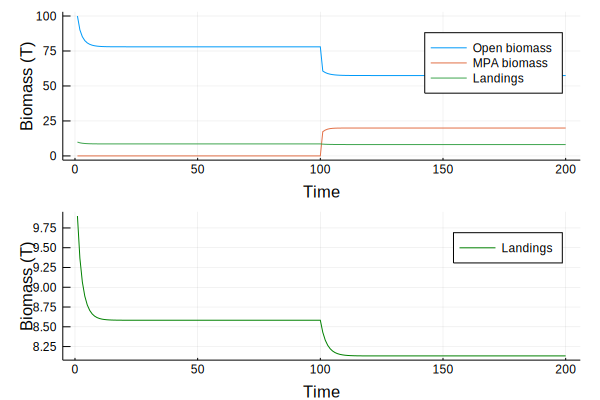

In [30]:
nsim = 200
NNres = zeros(nsim)
NNopen = zeros(nsim)
landings = zeros(nsim)

for t in 1:nsim
    NNres[t] = ground.Nreserve
    NNopen[t] = ground.Nopen
    # introduce a reseve covering 20% of area at 100th timestep
    if t == 100
        global α = 0.2
        m.set_protected!(ground, α)
    end
    landings[t] = m.update!(ground, fishers)
end

p1 = plot(NNopen, label="Open biomass", 
    xlabel="Time", ylabel="Biomass (T)");
plot!(p1, NNres, label="MPA biomass");
plot!(p1, landings, label="Landings");
p2 = plot(landings, label="Landings", linecolor=:green,
    xlabel="Time", ylabel="Biomass (T)");
plot(p1, p2, layout=(2,1))
